# Some errors in "Robustness" of Quantecon

I encountered some errors when replicating the results in the lecture "[Robustness](https://lectures.quantecon.org/py/robustness.html)" of Quantecon. 

The errors came from the failure of `LQ` in calculating stationary values of the example monopolist model. 

With the help of `olrp` and `olrprobust`, I was able to find the correct values and match the graph in the lecture.

## 1. The codes from "Robustness" cannot replicate their associated graph

I copied the codes from the "Robustness" chapter of Quantecon below:

In [1]:
"""

Authors: Chase Coleman, Spencer Lyon, Thomas Sargent, John Stachurski

(Copied from "Robustness" of Quantecon on June 27, 2017)

"""
import pandas as pd
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
import quantecon as qe

# == model parameters == #

a_0 = 100
a_1 = 0.5
ρ = 0.9
σ_d = 0.05
β = 0.95
c = 2
γ = 50.0

θ = 0.002
ac = (a_0 - c) / 2.0

# == Define LQ matrices == #

R = np.array([[0.,   ac,   0.],
              [ac, -a_1,  0.5],
              [0.,  0.5,  0.]])

R = -R  # For minimization
Q = γ / 2

A = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., ρ]])
B = np.array([[0.],
              [1.],
              [0.]])
C = np.array([[0.],
              [0.],
              [σ_d]])

# -------------------------------------------------------------------------- #
#                                 Functions
# -------------------------------------------------------------------------- #


def evaluate_policy(θ, F):
    """
    Given θ (scalar, dtype=float) and policy F (array_like), returns the
    value associated with that policy under the worst case path for {w_t}, as
    well as the entropy level.
    """
    rlq = qe.robustlq.RBLQ(Q, R, A, B, C, β, θ)
    K_F, P_F, d_F, O_F, o_F = rlq.evaluate_F(F)
    x0 = np.array([[1.], [0.], [0.]])
    value = - x0.T @ P_F @ x0 - d_F
    entropy = x0.T @ O_F @ x0 + o_F
    return list(map(float, (value, entropy)))


def value_and_entropy(emax, F, bw, grid_size=1000):
    """
    Compute the value function and entropy levels for a θ path
    increasing until it reaches the specified target entropy value.

    Parameters
    ==========
    emax: scalar
        The target entropy value

    F: array_like
        The policy function to be evaluated

    bw: str
        A string specifying whether the implied shock path follows best
        or worst assumptions. The only acceptable values are 'best' and
        'worst'.

    Returns
    =======
    df: pd.DataFrame
        A pandas DataFrame containing the value function and entropy
        values up to the emax parameter. The columns are 'value' and
        'entropy'.

    """
    if bw == 'worst':
        θs = 1 / np.linspace(1e-8, 1000, grid_size)
    else:
        θs = -1 / np.linspace(1e-8, 1000, grid_size)

    df = pd.DataFrame(index=θs, columns=('value', 'entropy'))

    for θ in θs:
        df.loc[θ] = evaluate_policy(θ, F)
        if df.loc[θ, 'entropy'] >= emax:
            break

    df = df.dropna(how='any')
    return df


# -------------------------------------------------------------------------- #
#                                    Main
# -------------------------------------------------------------------------- #


# == Compute the optimal rule == #
optimal_lq = qe.lqcontrol.LQ(Q, R, A, B, C, β)
Po, Fo, do = optimal_lq.stationary_values()

# == Compute a robust rule given θ == #
baseline_robust = qe.robustlq.RBLQ(Q, R, A, B, C, β, θ)
Fb, Kb, Pb = baseline_robust.robust_rule()

# == Check the positive definiteness of worst-case covariance matrix to == #
# == ensure that θ exceeds the breakdown point == #
test_matrix = np.identity(Pb.shape[0]) - (C.T @ Pb @ C) / θ
eigenvals, eigenvecs = eig(test_matrix)
assert (eigenvals >= 0).all(), 'θ below breakdown point.'


emax = 1.6e6

optimal_best_case = value_and_entropy(emax, Fo, 'best')
robust_best_case = value_and_entropy(emax, Fb, 'best')
optimal_worst_case = value_and_entropy(emax, Fo, 'worst')
robust_worst_case = value_and_entropy(emax, Fb, 'worst')

fig, ax = plt.subplots(figsize=(11,8))

ax.set_xlim(0, emax)
ax.set_ylabel("Value")
ax.set_xlabel("Entropy")
ax.grid()

for axis in 'x', 'y':
    plt.ticklabel_format(style='sci', axis=axis, scilimits=(0, 0))

plot_args = {'lw': 2, 'alpha': 0.7}

colors = 'r', 'b'

df_pairs = ((optimal_best_case, optimal_worst_case),
            (robust_best_case, robust_worst_case))


class Curve:

    def __init__(self, x, y):
        self.x, self.y = x, y

    def __call__(self, z):
        return np.interp(z, self.x, self.y)


for c, df_pair in zip(colors, df_pairs):
    curves = []
    for df in df_pair:
        # == Plot curves == #
        x, y = df['entropy'], df['value']
        x, y = (np.asarray(a, dtype='float') for a in (x, y))
        egrid = np.linspace(0, emax, 100)
        curve = Curve(x, y)
        ax.plot(egrid, curve(egrid), color=c, **plot_args)
        curves.append(curve)
    # == Color fill between curves == #
    ax.fill_between(egrid,
                    curves[0](egrid),
                    curves[1](egrid),
                    color=c, alpha=0.1)

plt.show()

ValueError: Convergence failed after 501 iterations.

The resulting graph from the codes is inconsistent with the graph from the lecture below:
<img src="https://lectures.quantecon.org/_images/kg_small_theta.png" alt="Alt text that describes the graphic" title="Title text" />

Now let's find out why.

## 2. Comparison test of "Robustness" codes with `olrp` and `olrprobust`

We first calculate the ordinary and robust decision rules using `olrp` and `olrprobust` respectively.

We then compare the results with those from "Robustness".

In [2]:
from olrp import olrp
from olrprobust import olrprobust

Fo2, Po2 = olrp(β,A,B,R,Q)
Fb2, Kb2, Pb2,_ = olrprobust(β,A,B,C,R,Q,-1/θ) # sig = -1/theta

# Print results
np.set_printoptions(suppress=True)

print('===== Policy Function F =====')
print('Fo from "Robustness": \n', np.round(Fo,3))
print('Fo from olrp: \n', np.round(Fo2,3))
print('Fb from "Robustness": \n', np.round(Fb,3))
print('Fb from olrprobust: \n', np.round(Fb2,3))
print('\n')
print('===== Value Function P =====')
print('Po from "Robustness": \n', np.round(Po,3))
print('Po from olrp: \n', np.round(Po2,3))
print('Pb from "Robustness": \n', np.round(Pb,3))
print('Pb from olrprobust: \n', np.round(Pb2,3))


===== Policy Function F =====
Fo from "Robustness": 
 [[-1.068  0.134 -0.058]]
Fo from olrp: 
 [[-10.75    0.11   -0.064]]
Fb from "Robustness": 
 [[-3.279  0.233 -0.029]]
Fb from olrprobust: 
 [[-3.279  0.233 -0.029]]


===== Value Function P =====
Po from "Robustness": 
 [[-1.40911542e+18 -3.06240000e+01 -2.33500000e+01]
 [-3.06240000e+01  2.77700000e+00 -2.84200000e+00]
 [-2.33500000e+01 -2.84200000e+00 -4.90000000e-01]]
Po from olrp: 
 [[-64900.489   -317.75    -132.728]
 [  -317.75       3.242     -2.094]
 [  -132.728     -2.094     -0.495]]
Pb from "Robustness": 
 [[-3170.206  -130.973   -13.402]
 [ -130.973     6.335    -1.22 ]
 [  -13.402    -1.22     -0.088]]
Pb from olrprobust: 
 [[-3170.206  -130.973   -13.402]
 [ -130.973     6.335    -1.22 ]
 [  -13.402    -1.22     -0.088]]


We can see that the ordinary `LQ` decision rules are significantly different from those by `olrp`. 

However, with a concern of robustness the results are the same between "Robustness" and `olrprobust`.

That means the issue comes from calculating stationary values in the ordinary LQ control problem, which is `qe.lqcontrol.LQ.stationary_values`.

Now let's use the ordinary decision rules from `olrp` and re-plot the graph.

## 3. Plot the graph with `olrp` and `olrprobust` decision rules

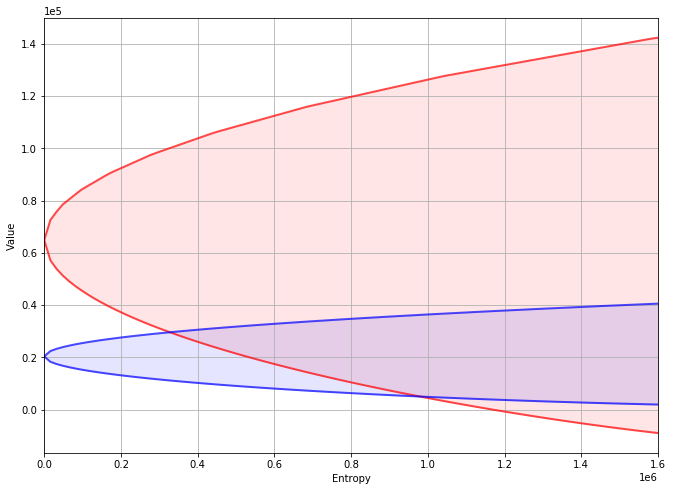

In [3]:
optimal_best_case = value_and_entropy(emax, Fo2, 'best')
robust_best_case = value_and_entropy(emax, Fb2, 'best')
optimal_worst_case = value_and_entropy(emax, Fo2, 'worst')
robust_worst_case = value_and_entropy(emax, Fb2, 'worst')

fig, ax = plt.subplots(figsize=(11,8))

ax.set_xlim(0, emax)
ax.set_ylabel("Value")
ax.set_xlabel("Entropy")
ax.grid()

for axis in 'x', 'y':
    plt.ticklabel_format(style='sci', axis=axis, scilimits=(0, 0))

plot_args = {'lw': 2, 'alpha': 0.7}

colors = 'r', 'b'

df_pairs = ((optimal_best_case, optimal_worst_case),
            (robust_best_case, robust_worst_case))


class Curve:

    def __init__(self, x, y):
        self.x, self.y = x, y

    def __call__(self, z):
        return np.interp(z, self.x, self.y)


for c, df_pair in zip(colors, df_pairs):
    curves = []
    for df in df_pair:
        # == Plot curves == #
        x, y = df['entropy'], df['value']
        x, y = (np.asarray(a, dtype='float') for a in (x, y))
        egrid = np.linspace(0, emax, 100)
        curve = Curve(x, y)
        ax.plot(egrid, curve(egrid), color=c, **plot_args)
        curves.append(curve)
    # == Color fill between curves == #
    ax.fill_between(egrid,
                    curves[0](egrid),
                    curves[1](egrid),
                    color=c, alpha=0.1)

plt.show()

The resulting graph is consistent with the graph from "Robustness".